Connected to integrating (Python 3.11.5)

In [1320]:
from PointList import *
%matplotlib widget 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from tqdm import tqdm
import math


In [1071]:
c = PointList()
c.add_point((2,3,0))
c.add_point((1,7,2))
c.add_point((5,9,0))
c.add_point((10,8,5))
c.add_point((11,4,-2))



In [1358]:
from PointList import *
from Triangle import *
from tqdm import tqdm
from copy import *


class TriangularMesh:
    def __init__(self, boundary : PointList, desired_triangle_count):
        self.boundary = boundary 
        self.m = desired_triangle_count
        self.mesh = []
        self.n = len(boundary.points)
        self.v_indexes = [] #the vertexes indices
        self.mapping = [] #contains the mapping from I(v_indexes) to R^3
        self.triangles  = []  #each triangle is a tuple
        self.inside_indexes  = []
        self.N = {} #les indices des voisins 
        self.N_vertexes = len(self.v_indexes) # the number of nodes in the meshing
        self.w = np.empty((len(self.v_indexes),len(self.v_indexes)))
        self.dict_vertexes = {} # contains the dict of all triangles associated to an index
        self.edges = set()
        self.vertex_curvatures = dict()
    

    def add_points_to_boundary(self,N = 10):
        "adding points to the boundary"
        K = deepcopy(self.boundary.points)
        R = []
        for i in tqdm(range(len(self.boundary.points))):
            
            p1 = K[i-1]
            p2 = K[i]
            L = list(np.linspace(p1,p2,N+2))[1:-1]

            R.append(p1)
            R = R + L
        self.boundary.points = R
        self.n = len(self.boundary.points)



    def compute_central_point(self):
        return self.boundary.average_point()
        
         
    def create_initial_subdivisions(self):
        #  Create initial subdivisions using the central point
        C = self.compute_central_point()
        s = int(self.m/(2*self.n) - 1/2)
        triangle = self.boundary.points + [self.boundary.points[0]]
        P = [triangle]
        for j in range(1,s+1):
            P_j = triangle + (j / (s+1))*(C - triangle)
            P.append(P_j)
        
        return np.array(P)
        

    def create_quadrilaterals(self):
        #split the outside quadrilaterals
        P = self.create_initial_subdivisions()
        s = int(self.m/(2*self.n) - 1/2)
        for j in tqdm(range(s)) : 
            for i in range(self.n) :
                self.mesh.append([P[j,i],P[j+1,i+1],P[j,i+1]])
                self.mesh.append([P[j,i],P[j+1,i+1],P[j+1,i]])
        
        


    def split_quadrilateral(self):
        C = self.compute_central_point()
        P = self.create_initial_subdivisions()
        for i in tqdm(range(self.n)) :
            self.mesh.append([C,P[-1,i],P[-1,i+1]])

    def further_subdivide(self):
        while len(self.mesh) < self.m :
            k = np.random.randint(0,len(self.mesh))
            tri = np.array(self.mesh.pop(k))
            C = np.mean(tri,axis = 0)
            tri1 = [tri[0],tri[1],C]
            tri2 = [tri[0],tri[2],C]
            tri3 = [tri[1],tri[2],C]
            self.mesh += [tri1,tri2,tri3]
    



    def generate_mesh_initial(self):
        self.create_quadrilaterals()
        # self.further_subdivide()
        return self.mesh


    def modify_N(self,i):
        N = []
        for tr in self.triangles :
            if i in tr:
                N += list(tr)
        self.N[i] = list(set(N))
        self.N[i].remove(i)


    def canonic_representation_from_mesh(self):
        K = np.array(self.mesh).reshape(-1,3)
        K = [tuple(x) for x in K]
        N = len(set(K))
        self.N_vertexes = N
        self.w = np.empty((N,N))
        self.v_indexes = list(range(N))
        self.mapping = list(set(K))
        for j in self.v_indexes:
            self.dict_vertexes[j] = []
        self.triangles = []
        for tri in self.mesh:
            triangle = [self.mapping.index(tuple(pt)) for pt in tri]
            self.triangles.append(triangle)
            self.dict_vertexes[triangle[0]].append(tuple(triangle))
            self.dict_vertexes[triangle[1]].append(tuple(triangle))
            self.dict_vertexes[triangle[2]].append(tuple(triangle))

        for i in self.v_indexes:
            self.modify_N(i)

        Outside = [tuple(k) for k in self.boundary.points]
        Outside_vertexes = [self.mapping.index((pt)) for pt in Outside]
        self.inside_indexes = list(set(self.v_indexes) - set(Outside_vertexes))

    
    def tuple_mapping(self):
        self.mapping = [tuple(k) for k in self.mapping]

            
    def clean_triangles(self):
        pass

    def area_3D(self,tr):
        v = [self.mapping[tr[0]],self.mapping[tr[1]],self.mapping[tr[2]]]
        return area_3D(v)


    def _N(self,i):
        N = []
        for tr in self.triangles :
            if i in tr:
                N += list(tr)
        return list(set(N))








    def cotangent_angle(self, p1, p2, p3):
        """Compute the cotangent of the angle between p1-p2 and p1-p3."""
        v1 = np.array(self.mapping[p2]) - np.array(self.mapping[p1])
        v2 = np.array(self.mapping[p3]) - np.array(self.mapping[p1])
        dot_product = np.dot(v1, v2)
        cross_product_norm = np.linalg.norm(np.cross(v1, v2))
        return dot_product / cross_product_norm

    def voronoi(self,p1,p2,p3):
        """Compute vornoi area at point p"""

        p = np.array(self.mapping[p1])
        q = np.array(self.mapping[p2])
        r = np.array(self.mapping[p3])
        pr = np.linalg.norm(p-r)**2
        pq = np.linalg.norm(p-q)**2
        cot_q = self.cotangent_angle(p2,p3,p1)
        cot_r = self.cotangent_angle(p3,p1,p2)
    
        return (pr*cot_q + pq*cot_r)/8
    

    def is_obtuse(self,p1, p2,p3):
        v1 = self.mapping[p1]
        v2 = self.mapping[p2]
        v3 = self.mapping[p3]
        # Compute squared lengths of the sides
        a2 = (v2[0]-v3[0])**2 + (v2[1]-v3[1])**2 + (v2[2]-v3[2])**2
        b2 = (v1[0]-v3[0])**2 + (v1[1]-v3[1])**2 + (v1[2]-v3[2])**2
        c2 = (v1[0]-v2[0])**2 + (v1[1]-v2[1])**2 + (v1[2]-v2[2])**2

        # Check if any angle is obtuse
        return a2 > b2 + c2 or b2 > a2 + c2 or c2 > a2 + b2


    def obtuse_at_point(self,p1, p2,p3):
        v1 = self.mapping[p1]
        v2 = self.mapping[p2]
        v3 = self.mapping[p3]
        # Compute squared lengths of the sides
        a2 = (v2[0]-v3[0])**2 + (v2[1]-v3[1])**2 + (v2[2]-v3[2])**2
        b2 = (v1[0]-v3[0])**2 + (v1[1]-v3[1])**2 + (v1[2]-v3[2])**2
        c2 = (v1[0]-v2[0])**2 + (v1[1]-v2[1])**2 + (v1[2]-v2[2])**2

        # Check if any angle is obtuse
        return a2 > b2 + c2 
    

    def mixed_area(self,v1,v2,v3):
        " calculate the voronoi mixed area at v1 "
        if not self.is_obtuse(v1,v2,v3): # checks that the triangle is not obtuse
            return self.voronoi(v1,v2,v3)
        else:
            tr = (v1,v2,v3)
            if self.obtuse_at_point(v1,v2,v3):
                
                return self.area_3D(tr)/2
            else:
                return self.area_3D(tr)/4

    def voronoi_area(self, vertex):
        """Compute the total area of triangles adjacent to the vertex."""
        area = 0
    
        triangles = self.dict_vertexes[vertex]
        for tri in triangles:
            v1 = vertex
            v2 = [a for a in tri if a != vertex][0]
            v3 = [a for a in tri if a != vertex][1]
            tr = (v1,v2,v3)
            area += self.area_3D(tr)
        return area


    def compute_mean_curvature(self):
        """Compute the mean curvature for each vertex in the mesh."""
        self.vertex_curvatures = dict()
        for i in self.inside_indexes:

            A_i = self.voronoi_area(i) #We do it with simple area
            curvature_sum = np.zeros(3)
            B_i  = 0
            for j in self.N[i]:
                
                tr_i = set(self.dict_vertexes[i])
                tr_j = set(self.dict_vertexes[j])

                t1= list(tr_i.intersection(tr_j))[0]
                t2= list(tr_i.intersection(tr_j))[1]
                

                alpha = [r for r in t1 if r not in (i,j)][0]
                beta = [r for r in t2 if r not in (i,j)][0]

                cot_alpha = self.cotangent_angle(alpha,i,j)
                cot_beta = self.cotangent_angle(beta,j,i)

                p_i = np.array(self.mapping[i]) 
                p_j = np.array(self.mapping[j]) 

                curvature_sum += (cot_alpha + cot_beta) *(p_j - p_i)
                
                if A_i < 0:
                    print(A_i,i)
                    raise Exception("Error this area si negative !!!")
                    

            
            h_i = np.linalg.norm(curvature_sum) / (4 * A_i)
            self.vertex_curvatures[h_i] = i
        A = np.array(list(self.vertex_curvatures.keys()))
        
        return np.max(A)



In [1471]:
R = []
S2 = []
S1 = []
S3 = []
S4 = []

U = np.linspace(-3*np.pi/5,3*np.pi/5,2)
V = np.linspace(-2,2,15)
polygone = PointList()

for u in [-3*np.pi/5]  :
    for v in V :
        S2.append((np.cosh(v)*np.cos(u),np.cosh(v)*np.sin(u),v))
S2.reverse()
for u in [3*np.pi/5]  :
    for v in V :
        S3.append((np.cosh(v)*np.cos(u),np.cosh(v)*np.sin(u),v))


U = np.linspace(-3*np.pi/5,3*np.pi/5,65)
V = np.linspace(-2,2,2)

for u in U :
    for v in [-2] :
        S1.append((np.cosh(v)*np.cos(u),np.cosh(v)*np.sin(u),v))

for u in U :
    for v in [2] :
        S4.append((np.cosh(v)*np.cos(u),np.cosh(v)*np.sin(u),v))

S4.reverse()



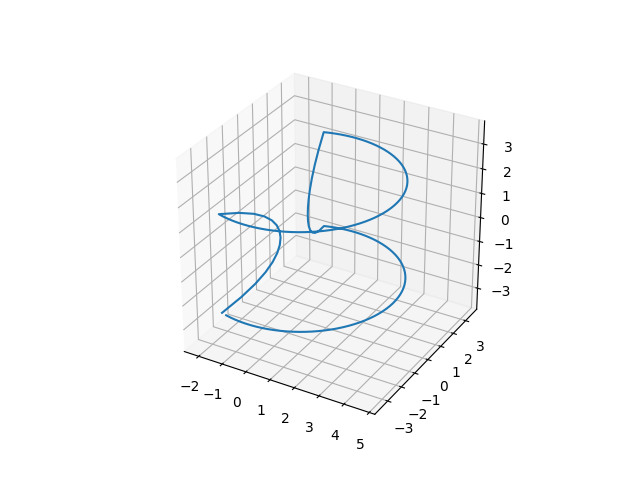

In [ ]:

X = []
Y = []
Z = []
S = S1[1:] + S3[1:] + S4[1:] + S2[1:] 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

L = np.array(S)
xs = L[:,0]
ys = L[:,1]
zs = L[:,2]

X = X + list(xs)
Y = Y + list(ys)
Z = Z + list(zs)

plt.plot(xs,ys,zs)


X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)

max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0 

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)


polygone.points = S


In [1473]:
len(S)

156

In [1321]:
#class of updating_Laplace 
def distance(point1, point2):
    """Compute the Euclidean distance between two points."""
    return np.linalg.norm(np.array(point1) - np.array(point2))

def perimeter_3D(vertices):
    """Compute the perimeter of a triangle given its vertices."""
    return distance(vertices[0], vertices[1]) + distance(vertices[1], vertices[2]) + distance(vertices[0], vertices[2])


class Updating_Laplace(TriangularMesh):
    def __init__(self, boundary : PointList, desired_triangle_count):
        super().__init__(boundary, desired_triangle_count)

    def S(self,i,j):
        S = 0
        tr_i = set(self.dict_vertexes[i])
        tr_j = set(self.dict_vertexes[j])
        intersect = list(tr_i.intersection(tr_j))
        if len(intersect) != 2:
            print(intersect)
            raise Exception("Sorry, it should have only two adjacent triangles")
        for tr in intersect :
            S+= self.area_3D(tr)
        return S


    def calcul_weights(self,i,j) :
        S = 0
        for k in self.N[i]:
            S += (self.S(i,k))
        
        self.w[i,j] =  (self.S(i,j))/S
        if math.isnan(self.w[i,j]):
            print(i,j)
            raise ValueError("S is nega tive")


         


    def update_weights(self):
        "Updates the weights of the Mesh for each iteration"
        for i in self.inside_indexes:
            for j in self.inside_indexes:
                if i in self.N[j] :
                    self.calcul_weights(i,j)
                    

    def calculate_area(self):
        "Calculates the area of the meshing"
        S = 0
        for tri in self.triangles:
            S = S + self.area_3D(tri)
        return S

    def update_mapping(self,i):
        "Updates the position of the nodes using the Laplace Fairing"
        N_i = self.N[i]
        P = np.array([0,0,0])
        for k in N_i :
            P = P + (self.w[i,k])*np.array(self.mapping[k])
        
        self.mapping[i] = P

        for k in N_i:
            self.calcul_weights(i,k)

            
    
        



        

In [1354]:
class Edge_Flipping(Updating_Laplace):
    def __init__(self, boundary : PointList, desired_triangle_count):
        super().__init__(boundary, desired_triangle_count)
        self.dict_edges = dict()
        self.L = {}
        self.L_replaced = {}

    def fill_edges(self):
        self.edges = set()
        for tri in self.triangles:
            for i in range(3):
                edge = tuple(sorted([tri[i], tri[(i+1)%3]]))
                self.edges.add(edge)
                self.dict_edges[edge] = -1

    def test(self,edge,tri):
        return set(edge).issubset(set(tri))
    
    def can_flip(self,edge):
        triangles = [tuple(set(sorted(triangle)))  for triangle in self.triangles if self.test(edge,triangle)]
        return len(set(triangles)) == 2
    
    def flip_edge(self,edge):
        triangles = [triangle for triangle in self.triangles if self.test(edge,triangle)]
        if len(triangles) != 2 :
            print(edge,triangles)
        t1,t2 = triangles
        opposite_vertices = [v for v in t1 if v not in edge] + [v for v in t2 if v not in edge]

        new_triangles = [tuple(set([edge[0], opposite_vertices[0], opposite_vertices[1]])), 
                     tuple(set([edge[1], opposite_vertices[0], opposite_vertices[1]]))]
        for tr in new_triangles:
            if len(tr) != 3:
                print(edge,new_triangles,triangles)
                
                raise Exception("Sorry, the triangle is not well constructed")
                
        for triangle in triangles:
            self.triangles.remove(triangle)
        if len(set(new_triangles)) != 2:
            print(new_triangles)
        self.triangles.extend(new_triangles)
        return triangles,new_triangles
    
    def lawson_flip(self):
        self.L = {}
        self.L_replaced = {}
        swaped = True
        while swaped :
            
            swaped = False
            i = 0
            ll = len(self.edges)

            while i < len(list(self.edges)):
                
                edge = list(self.edges)[i]
                if self.can_flip(edge):
                    self.L[edge] = edge
                    old_tr, new_tr = self.flip_edge(edge)
                    
       
                    old_area = sum(self.area_3D(triangle) for triangle in old_tr)
                    new_area = sum(self.area_3D(triangle) for triangle in new_tr)
                    
                    R = set(np.array(new_tr).reshape(-1))
                    edge1 = tuple(sorted([a for a in R if a not in edge]))
                    
                    if new_area >=  old_area or edge1 in list(self.edges): 

                        for triangle in new_tr:
                            self.triangles.remove(triangle)
                        self.triangles.extend(old_tr)# Flip back if the new area is not smaller
                    else:
                        
                        swaped = True
                        self.edges.remove(edge)
                        self.edges.add(edge1)
                        
                    self.L[edge] = (new_area -  old_area, old_tr, new_tr,edge)
                if len(list(self.edges)) < ll:
                    print(edge,edge1)
                i = i+1



In [1484]:
#intialize the first mesh
from copy import *

polygone = PointList()
for k in S:
    polygone.add_point(k)
""
M = Edge_Flipping(polygone,2040)
# M.add_points_to_boundary(N = 5)
M.create_quadrilaterals()
M.split_quadrilateral()

M.canonic_representation_from_mesh()
M.clean_triangles()
M.fill_edges()

Outside = [tuple(k) for k in M.boundary.points]
Outside_vertexes = [M.mapping.index((pt)) for pt in Outside]
Inside_vertexes = list(set(M.v_indexes) - set(Outside_vertexes))

centre = M.compute_central_point()
centre = tuple(centre)
ind = M.mapping.index(centre)
triangle_centre = M.dict_vertexes[ind]
M.update_weights()
# Fliaring Laplace 
# epsilon = 0.01
# area = M.calculate_area()
# M.update_weights()
# for i in Inside_vertexes:
#     M.update_mapping(i)
# M.lawson_flip()

# new_area = M.calculate_area()
# while area - new_area >= epsilon:
#     area = M.calculate_area()
#     M.update_weights()
#     for i in Inside_vertexes:
#         M.update_mapping(i)
#     M.lawson_flip()
    
#     new_area = M.calculate_area()
    
#     print(new_area,area - new_area,M.compute_mean_curvature(),M.vertex_curvatures[M.compute_mean_curvature()])


# # # M.canonic_representation()
M.compute_mean_curvature()


100%|██████████| 156/156 [00:00<00:00, 140319.84it/s]


2.2185798194293067

In [1485]:
epsilon = 0.01
area = M.calculate_area()

for i in tqdm(Inside_vertexes):
    M.update_mapping(i)
M.lawson_flip()
new_area = M.calculate_area()
print(new_area,area - new_area,M.compute_mean_curvature(),M.vertex_curvatures[M.compute_mean_curvature()])

while  True:
    area = M.calculate_area()

    for i in Inside_vertexes:
        M.update_mapping(i)
    M.lawson_flip()

    new_area = M.calculate_area()

    print(new_area,area - new_area,M.compute_mean_curvature(),M.vertex_curvatures[M.compute_mean_curvature()])


100%|██████████| 937/937 [00:00<00:00, 1025.14it/s]


92.75854918409966 -29.848824919183123 5.782654604146901 979
66.768209119602 25.99034006449766 4.425989402262448 1071
64.59644013432771 2.171768985274298 3.6787562146370583 226
63.80733810861166 0.7891020257160477 1.4407711883514311 95
62.64428539737241 1.1630527112392528 1.691384935322517 987
62.50902772928666 0.13525766808574957 1.0784228278208863 198
62.25440064560045 0.25462708368620923 1.2097085984090465 31
62.17562501869494 0.07877562690551088 1.1370545265408882 565
62.06485260823785 0.11077241045708774 1.0011756766153974 565
62.01651784216621 0.048334766071640445 0.9579807339732118 31
61.986692839908265 0.029825002257943822 0.9946748675906885 565
61.951222595784145 0.03547024412412014 0.862328307853861 31
61.93657741171765 0.014645184066495176 0.8714594425211301 565
61.88749109251547 0.04908631920218198 0.8673201844789368 565
61.893890945106875 -0.006399852591407296 0.8027721820087808 40
61.87382162463637 0.020069320470504692 0.8447563496848622 565
61.853044382354156 0.0207772422

KeyboardInterrupt: 

(-3.76147049205584, 3.76147049205584)

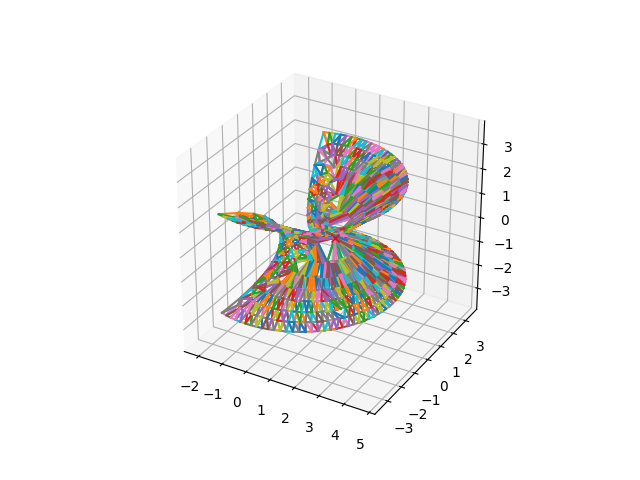

In [1491]:
#Drawing the surfaces 





fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
X = []
Y = []
Z = []
for tr in M.triangles:
    xs = [M.mapping[ind][0] for ind in tr] + [M.mapping[tr[0]][0]]
    ys = [M.mapping[ind][1] for ind in tr] + [M.mapping[tr[0]][1]]
    zs = [M.mapping[ind][2] for ind in tr] + [M.mapping[tr[0]][2]]
    ax.plot(xs,ys,zs)
    
    X = X + list(xs)
    Y = Y + list(ys)
    Z = Z + list(zs)



# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# for i in range(len(P)):
#     L = P[i]
#     L = np.array(L)
#     xs = L[:,0]
#     ys = L[:,1]
#     zs = L[:,2]

#     ax.plot(xs,ys,zs,color='green')
    




# L = M.boundary.points
# L = np.array(L)
# L = np.array(L)
# x = L[:,0]
# y = L[:,1]
# z = L[:,2]



# plt.plot(x,y,z,'o') 

# L = M.boundary.points
# L = np.array(L)
# L = np.array(L)

L = M.mapping[ind]
x = L[0]
y = L[1]
z = L[2]


plt.plot(x,y,z,'x',color='r') 





# for tr in triangles:
#     print(tr)
    
#     xs = [M.mapping[ind][0] for ind in tr] + [M.mapping[tr[0]][0]]
#     ys = [M.mapping[ind][1] for ind in tr] + [M.mapping[tr[0]][1]]
#     zs = [M.mapping[ind][2] for ind in tr] + [M.mapping[tr[0]][2]]

#     print(xs,ys,zs)

#     ax.plot(xs,ys,zs,color = 'r')
#     X = X + list(xs)
#     Y = Y + list(ys)
#     Z = Z + list(zs)

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0 

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)



In [1438]:
for s in TTT:
    M.update_mapping(s)

In [1418]:
L = M.vertex_curvatures.values()
L = list(L)
val = list(M.vertex_curvatures.keys())[L.index(ind)]
M.vertex_curvatures[val]



417

In [ ]:
M.dict_vertexes

In [1487]:
TTT = set()
for k in M.N[ind]:
    TTT.add(k)
    for j in M.N[k]:
        TTT.add(j)

In [1488]:
triangles = M.dict_vertexes[ind]
for k in TTT:
    triangles = triangles + M.dict_vertexes[k]

In [1158]:
# Now we use the mixed area 
def is_obtuse(v1, v2, v3):
    # Compute squared lengths of the sides
    a2 = (v2[0]-v3[0])**2 + (v2[1]-v3[1])**2 + (v2[2]-v3[2])**2
    b2 = (v1[0]-v3[0])**2 + (v1[1]-v3[1])**2 + (v1[2]-v3[2])**2
    c2 = (v1[0]-v2[0])**2 + (v1[1]-v2[1])**2 + (v1[2]-v2[2])**2

    # Check if any angle is obtuse
    return a2 > b2 + c2 or b2 > a2 + c2 or c2 > a2 + b2



def obtuse_at_point(v1,v2,v3):
    # computes if the triangle is obtuse at v1
    a2 = (v2[0]-v3[0])**2 + (v2[1]-v3[1])**2 + (v2[2]-v3[2])**2
    b2 = (v1[0]-v3[0])**2 + (v1[1]-v3[1])**2 + (v1[2]-v3[2])**2
    c2 = (v1[0]-v2[0])**2 + (v1[1]-v2[1])**2 + (v1[2]-v2[2])**2

    return a2 > b2 + c2


def circumcenter(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    
    ba = b - a
    ca = c - a
    
    cross_product1 = np.cross(ba, ca)
    cross_product2 = np.cross(ca, ba) 
    denominator = 2 * np.dot(cross_product1, cross_product1)
    
    term1 = np.linalg.norm(ca)**2 * np.cross(cross_product1, ba)
    term2 = np.linalg.norm(ba)**2 * np.cross(cross_product2, ca)
    
    J = a + (term1 + term2) / denominator
    
    return tuple(J)

def area(V1,V2,V3):
    area_vector = np.cross(V2 - V1, V3 - V1)
    area = 0.5 * np.linalg.norm(area_vector)
    print(area)
    return area


def voronoi(p,q,r):
    "vornoi area at point a"
    pr = np.linalg.norm(p-r)**2
    pq = np.linalg.norm(p-q)**2
    cot_q = cot(r,q,p)
    cot_r = cot(q,r,p)
    
    return (pr*cot_q + pq*cot_r)/8


def mixed_area(v1,v2,v3):
    " calculate the voronoi mixed area at v1 "
    if not is_obtuse(v1,v2,v3): # checks that the triangle is not obtuse
        return voronoi(v1,v2,v3)
    else:
        if obtuse_at_point(v1,v2,v3):
            return area(v1,v2,v3)/2
        else:
            return area(v1,v2,v3)/4



In [1172]:
print(M.N[index_small])
print(M.dict_vertexes[index_small])
print(index_small)



[481, 521, 366, 532, 247]
[(521, 401, 532), (521, 401, 481), (532, 247, 401), (366, 481, 401), (366, 401, 247)]
401


(-0.1590314441264053, 0.5226678077627687)

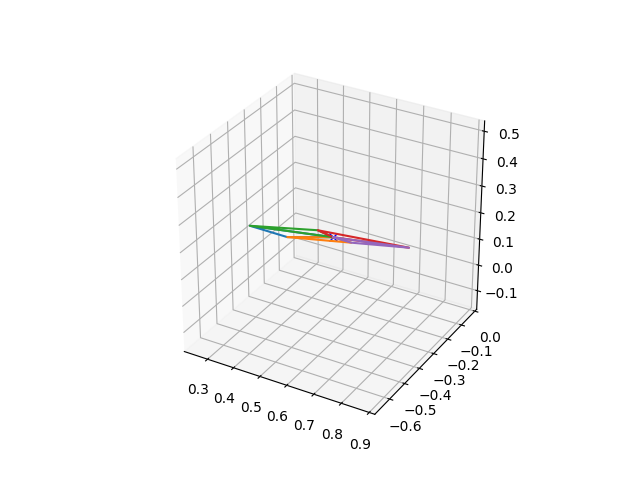

In [1119]:
A = np.array(M.mapping[481])
B = np.array(M.mapping[521])
C = np.array(M.mapping[532])
D = np.array(M.mapping[247])
E = np.array(M.mapping[366])
O = np.array(M.mapping[401])


triangles = [[O,B,C],[O,B,A],[O,C,D],[O,D,E],[O,E,A]]





fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
X = []
Y = []
Z = []



plt.plot(O[0],O[1],O[2],'x',color = "b")

for tr in triangles:
   
    
    xs = [ind[0] for ind in tr] + [tr[0][0]]
    ys = [ind[1] for ind in tr] + [tr[0][1]]
    zs = [ind[2] for ind in tr] + [tr[0][2]]

    

    ax.plot(xs,ys,zs)
    X = X + list(xs)
    Y = Y + list(ys)
    Z = Z + list(zs)

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0 

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)



In [1290]:
def cot(v2,v1,v3):
    a = v2 - v1
    b = v3 - v1
    dot_product = np.dot(a, b)
    cross_product_magnitude = np.linalg.norm(np.cross(a, b))

    cot_alpha = dot_product / cross_product_magnitude
    return cot_alpha

def surf(V1,V2,V3):
    area_vector = np.cross(V2 - V1, V3 - V1)
    area = 0.5 * np.linalg.norm(area_vector)
    return area

L1  = (cot(O,C,B) + cot(O,A,B))*(B - O)
L2  = (cot(O,B,C) + cot(O,D,C))*(C - O)
L3  = (cot(O,C,D) + cot(O,E,D))*(D - O)
L4  = (cot(O,D,E) + cot(O,A,E))*(E - O)
L5  = (cot(O,E,A) + cot(O,B,A))*(A - O)

D1  = (cot(O,C,B) + cot(O,A,B))*np.linalg.norm(B - O)
D2  = (cot(O,B,C) + cot(O,D,C))*np.linalg.norm(C - O)
D3  = (cot(O,C,D) + cot(O,E,D))*np.linalg.norm(D - O)
D4  = (cot(O,D,E) + cot(O,A,E))*np.linalg.norm(E - O)
D5  = (cot(O,E,A) + cot(O,B,A))*np.linalg.norm(A - O)

Sur1 = mixed_area(O,B,C)
Sur2 = mixed_area(O,B,A)
Sur3 = mixed_area(O,E,A)
Sur4 = mixed_area(O,E,D)
Sur5 = mixed_area(O,D,C)

surface = mixed_area(O,B,C) + mixed_area(O,B,A) + mixed_area(O,E,A) + mixed_area(O,E,D) + mixed_area(O,D,C)

somme = L1 + L2 + L3 + L4 + L5 
np.linalg.norm(somme)

ValueError: operands could not be broadcast together with shapes (3,) (756,) 

In [1197]:
i = index_small
A_i = M.voronoi_area(i)
area = 0

triangles = M.dict_vertexes[i]
for tri in triangles:
    v1 = i
    v2 = [a for a in tri if a != i][0]
    v3 = [a for a in tri if a != i][1]
    print(v1,v2,v3)
    area += M.mixed_area(v1,v2,v3)
    print(M.mixed_area(v1,v2,v3))



401 521 532
0.006720627006502371
401 521 481
0.004549340727298626
401 532 247
0.005464738839959456
401 366 481
0.0032752342454407516
401 366 247
0.006728898789614571


In [1286]:
M.lawson_flip()
M.update_weights()
for i in tqdm(Inside_vertexes):
    M.update_mapping(i)
M.compute_mean_curvature()

100%|██████████| 761/761 [00:01<00:00, 479.66it/s]


11.754684274268524

In [1169]:
L = list(M.vertex_curvatures.values())
index_here = L.index(index_small)
list(M.vertex_curvatures.keys())[index_here]

5.535534722167319

(-4.5, 5.5)

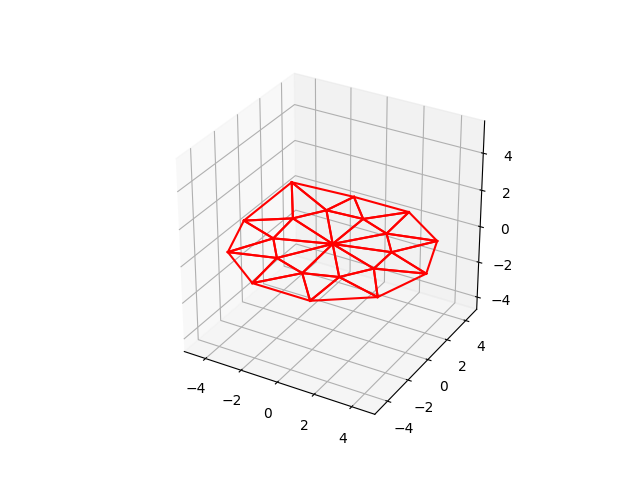

In [1273]:
# n_points = 10

# # Radius of the circle
# r = 5  # For example, radius = 1
# z = 0
# # Calculate the coordinates of the points
# points = np.array([[r * np.cos(2 * np.pi * i / n_points), r * np.sin(2 * np.pi * i / n_points), z] for i in range(n_points)])
# points = list(points) + [points[0]]
# points[4][-1] += 1


# P = [points]

# r = 2 # For example, radius = 1
# z = 5
# # Calculate the coordinates of the points
# points_1 = np.array([[r * np.cos(2 * np.pi * i / n_points), r * np.sin(2 * np.pi * i / n_points), z] for i in range(n_points)])
# points_1 = list(points_1) + [points_1[0]]
# P.append(points_1)
# points_1[6][1] += 1

# P = np.array(P)
# mesh = []
# print(P)
# for j in tqdm(range(1)) : 
#     for i in range(n_points) :
#         mesh.append([P[j,i],P[j+1,i+1],P[j,i+1]])
#         mesh.append([P[j,i],P[j+1,i+1],P[j+1,i]])


# for i in range(n_points) :
#     mesh.append([P[1,i],C,P[1,i+1]])

# c = PointList()
# for pt in points[:-1]:
#     c.add_point(pt)



# RR = Edge_Flipping(c,0)
# RR.mesh = mesh
# RR.canonic_representation_from_mesh()

# # RR.update_weights()
# for i in RR.inside_indexes:
#     RR.update_mapping(i)
# # RR.lawson_flip()
    
# P = P.reshape(-1,3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')

X = []
Y = []
Z = []

# plt.plot(X,Y,Z,"x")
for tr in RR.triangles:

    
    xs = [RR.mapping[ind][0] for ind in tr] + [RR.mapping[tr[0]][0]]
    ys = [RR.mapping[ind][1] for ind in tr] + [RR.mapping[tr[0]][1]]
    zs = [RR.mapping[ind][2] for ind in tr] + [RR.mapping[tr[0]][2]]


    
    ax.plot(xs,ys,zs,color = 'r')
    X = X + list(xs)
    Y = Y + list(ys)
    Z = Z + list(zs)

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0 

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)


In [1271]:
# c = PointList()
# for pt in points[:-1]:
#     c.add_point(pt)



# RR = Edge_Flipping(c,0)
# RR.mesh = mesh
# RR.canonic_representation_from_mesh()

RR.update_weights()
for i in RR.inside_indexes:
    RR.update_mapping(i)
RR.lawson_flip()






In [1272]:
RR.compute_mean_curvature()

0.01317334062694234

22.42795653500788

In [179]:
2*np.random.random((3)) - 1

array([0.61040918, 0.44901424, 0.57356086])

In [207]:
dict_try = {}
for _ in range(10000):
    O = O + 2*np.random.random((3)) - 1
    L1  = (cot(O,C,B) + cot(O,A,B))*(B - O)
    L2  = (cot(O,B,C) + cot(O,D,C))*(C - O)
    L3  = (cot(O,C,D) + cot(O,E,D))*(D - O)
    L4  = (cot(O,D,E) + cot(O,A,E))*(E - O)
    L5  = (cot(O,E,A) + cot(O,B,A))*(A - O)

    D1  = (cot(O,C,B) + cot(O,A,B))*np.linalg.norm(B - O)
    D2  = (cot(O,B,C) + cot(O,D,C))*np.linalg.norm(C - O)
    D3  = (cot(O,C,D) + cot(O,E,D))*np.linalg.norm(D - O)
    D4  = (cot(O,D,E) + cot(O,A,E))*np.linalg.norm(E - O)
    D5  = (cot(O,E,A) + cot(O,B,A))*np.linalg.norm(A - O)


    surface = mixed_area(O,B,C) + mixed_area(O,B,A) + mixed_area(O,E,A) + mixed_area(O,E,D) + mixed_area(O,D,C)

    somme = L1 + L2 + L3 + L4 + L5 
    dict_try[2*np.linalg.norm(somme)/2] =  tuple(O)
    


In [208]:
pluspetit = np.min(list(dict_try.keys()))
[pluspetit]


[2.586652795803095]

In [9]:
mesh


array([[[ 1,  2,  5],
        [ 2,  6,  0],
        [ 2, -1,  0]],

       [[ 3,  2,  5],
        [ 2, -1,  0],
        [ 2,  6,  0]]])

In [267]:
P

array([ 0.08787578, -0.66474374, -0.389626  ])

In [268]:
M.mapping[i]

(0.09317136285814992, -0.6575330878841943, -0.39676113360323895)

In [265]:
max(R)

1.0000000000000002

In [1019]:
def can_flip(edge, mesh):
    triangles = [triangle for triangle in mesh if set(edge).issubset(set(vertices(triangle)))]
    return len(triangles) == 2

def flip_edge(edge, mesh):
    triangles = [triangle for triangle in mesh if set(edge).issubset(set(vertices(triangle)))]
    print(edge,triangles)
    t1, t2 = triangles
    
    
    opposite_vertices = [v for v in vertices(t1) if v not in edge] + [v for v in vertices(t2) if v not in edge]
    new_triangles = [[edge[0], opposite_vertices[0], opposite_vertices[1]], 
                     [edge[1], opposite_vertices[0], opposite_vertices[1]]]
    for triangle in triangles:
        mesh.remove(triangle)
    mesh.extend(new_triangles)
    
    
    return triangles,new_triangles

def vertices(triangle):
    v = []
    for k in triangle:
        v.append(tuple(k))
    return v

def lawson_flip(mesh):
    edges = set()
    for triangle in mesh:
        for i in range(3):
            edge = tuple(sorted([tuple(triangle[i]), tuple(triangle[(i+1)%3])]))
            edges.add(edge)
    for edge in edges:
        if can_flip(edge, mesh):
            triangles = [triangle for triangle in mesh if set(edge).issubset(set(vertices(triangle)))]
            old_area = sum(area_3D(triangle) for triangle in triangles)
            old_tr, new_tr = flip_edge(edge,mesh)
            triangles = [triangle for triangle in mesh if set(edge).issubset(set(vertices(triangle)))]
            new_area = sum(area_3D(triangle) for triangle in triangles)
            print(new_area - old_area)
            if new_area >= old_area:
                for triangle in new_tr:
                    mesh.remove(triangle)
                mesh.extend(old_tr)
     # Flip back if the new area is not smaller




In [248]:
def triangle_tuple(triangle):
    tr = (tuple(triangle[0]),tuple(triangle[1]),tuple(triangle[2]))
    return tr



def test(edge,triangle):
    tr = (tuple(triangle[0]),tuple(triangle[1]),tuple(triangle[2]))
    tr = set(tr)
    return set(edge).issubset(set(tr))

def can_flip(edge, mesh):
    triangles = [triangle for triangle in mesh if test(edge,triangle)]

    return len(triangles) == 2

def flip_edge(edge, mesh):
    
    triangles = [triangle for triangle in mesh if test(edge,triangle)]
    t1, t2 = triangles
    t1 , t2 = triangle_tuple(t1),triangle_tuple(t2)
    opposite_vertices = [v for v in t1 if v not in edge] + [v for v in t2 if v not in edge]
    new_triangles = [[edge[0], opposite_vertices[0], opposite_vertices[1]], 
                     [edge[1], opposite_vertices[0], opposite_vertices[1]]]
    for triangle in triangles:
        mesh.remove(triangle)
    mesh.extend(new_triangles)
    return triangles,new_triangles

def lawson_flip(mesh):
    edges = set()
    for triangle in mesh:
        for i in range(3):
            edge = tuple(sorted([tuple(triangle[i]), tuple(triangle[(i+1)%3])]))
            edges.add(edge)
    for edge in edges:
        if can_flip(edge, mesh):
            triangles = [triangle for triangle in mesh if test(edge,triangle)]
            old_area = sum(area_3D(triangle) for triangle in triangles)
            old_tr, new_tr = flip_edge(edge, mesh)
            new_area = sum(area_3D(triangle) for triangle in triangles)
            
            if new_area >=  old_area: 
                for triangle in new_tr:
                    mesh.remove(triangle)
                mesh.extend(old_tr)# Flip back if the new area is not smaller

L = [triangle_tuple(tr) for tr in M.mesh]
lawson_flip(L)